In [ ]:
pip install optuna transformers[torch] imbalanced-learn

### Load Library

In [ ]:
import pandas as pd
import torch
from transformers import BertTokenizer, BertForSequenceClassification, TrainingArguments, Trainer
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support, roc_auc_score, accuracy_score
from imblearn.over_sampling import RandomOverSampler
import numpy as np
import optuna

### Load Dataset

In [ ]:
# Load dataset
data = pd.read_csv('/content/drive/MyDrive/processed.csv')

### Konversi Label Ke Numerik

In [ ]:
# Konversi label ke numerik
label_mapping = {'Not-Fraud': 0, 'Fraud': 1}
data['Label'] = data['Label'].map(label_mapping)

### Split Dataset

In [ ]:
# Split dataset
train_texts, test_texts, train_labels, test_labels = train_test_split(data['cleaned_OCR_text'], data['Label'], test_size=0.2)

### Oversampling

In [ ]:
# Oversampling
ros = RandomOverSampler(random_state=42)
train_texts, train_labels = ros.fit_resample(np.array(train_texts).reshape(-1, 1), np.array(train_labels))

# Mengubah kembali ke bentuk semula
train_texts = train_texts.flatten()

# Reset index
train_labels = pd.Series(train_labels).reset_index(drop=True)
test_labels = test_labels.reset_index(drop=True)

### Tokenization

In [ ]:
# Tokenization
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')
train_encodings = tokenizer(list(train_texts), truncation=True, padding=True, max_length=128)
test_encodings = tokenizer(list(test_texts), truncation=True, padding=True, max_length=128)

tokenizer_config.json:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

In [ ]:
# Dataset class
class Dataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item

    def __len__(self):
        return len(self.labels)

In [ ]:
train_dataset = Dataset(train_encodings, train_labels)
test_dataset = Dataset(test_encodings, test_labels)

### Modeling

In [ ]:
# Load model
model = BertForSequenceClassification.from_pretrained('bert-base-multilingual-cased', num_labels=2)

model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Fungsi untuk menghitung metrik
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary', zero_division=0)
    auc = roc_auc_score(labels, preds)

    return {
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'roc_auc': auc,
        'accuracy': accuracy_score(labels, preds)
    }

In [ ]:
# Fungsi objective untuk Optuna
def objective(trial):
    # Definisikan rentang hyperparameter yang lebih luas
    learning_rate = trial.suggest_float("learning_rate", 3.5e-5, 4.5e-5)
    num_train_epochs = trial.suggest_int("num_train_epochs", 4, 6)
    per_device_train_batch_size = trial.suggest_categorical("per_device_train_batch_size", [16, 32])
    warmup_steps = trial.suggest_int("warmup_steps", 800, 1200)
    weight_decay = trial.suggest_float("weight_decay", 0.03, 0.05)
    adam_epsilon = trial.suggest_float("adam_epsilon", 6e-7, 8e-7)
    gradient_accumulation_steps = trial.suggest_categorical("gradient_accumulation_steps", [4, 5, 6])

    # Training arguments
    training_args = TrainingArguments(
        output_dir="./results",
        num_train_epochs=num_train_epochs,
        per_device_train_batch_size=per_device_train_batch_size,
        per_device_eval_batch_size=32,
        learning_rate=learning_rate,
        warmup_steps=warmup_steps,
        weight_decay=weight_decay,
        logging_dir="./logs",
        logging_steps=50,
        evaluation_strategy="epoch",
        save_strategy="epoch",
        eval_steps=100,
        save_steps=100,
        load_best_model_at_end=True,
        metric_for_best_model="roc_auc",
        report_to="none"
    )

    # Inisialisasi Trainer
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=test_dataset,
        compute_metrics=compute_metrics
    )

    # Train model
    trainer.train()

    # Evaluasi model
    eval_results = trainer.evaluate()

    # Menggabungkan skor ROC-AUC dan F1
    roc_auc = eval_results["eval_roc_auc"]
    f1_score = eval_results["eval_f1"]
    combined_score = (roc_auc + f1_score) / 2

    return combined_score

In [ ]:
# Membuat study dan menjalankan optimasi
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=20)

print("Best trial:")
trial = study.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2023-12-09 03:18:23,112] A new study created in memory with name: no-name-5ae1a6ad-71e4-4dba-b034-496d3e60b464


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Roc Auc,Accuracy
1,0.270100,0.404871,0.461538,0.521739,0.489796,0.719693,0.870466
2,0.247100,0.459011,0.411765,0.304348,0.350000,0.622762,0.865285
3,0.295800,0.517283,0.434343,0.623188,0.511905,0.756692,0.858377
4,0.151400,0.489986,0.492754,0.492754,0.492754,0.712063,0.879102


[I 2023-12-09 03:20:56,208] Trial 0 finished with value: 0.6342985020094994 and parameters: {'learning_rate': 4.424709551096267e-05, 'num_train_epochs': 4, 'per_device_train_batch_size': 16, 'warmup_steps': 903, 'weight_decay': 0.038811308821334906, 'adam_epsilon': 6.160322280128009e-07, 'gradient_accumulation_steps': 4}. Best is trial 0 with value: 0.6342985020094994.


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Roc Auc,Accuracy
1,0.133200,0.447946,0.523077,0.492754,0.507463,0.715985,0.886010
2,0.135500,0.498765,0.596491,0.492754,0.539683,0.723828,0.899827
3,0.186200,0.582848,0.555556,0.507246,0.530303,0.726172,0.892919
4,0.130700,0.511829,0.600000,0.521739,0.558140,0.737340,0.901554


[I 2023-12-09 03:23:35,009] Trial 1 finished with value: 0.6477398441682032 and parameters: {'learning_rate': 3.9869754540501254e-05, 'num_train_epochs': 4, 'per_device_train_batch_size': 16, 'warmup_steps': 951, 'weight_decay': 0.038845856915595944, 'adam_epsilon': 6.022623347451348e-07, 'gradient_accumulation_steps': 4}. Best is trial 1 with value: 0.6477398441682032.


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Roc Auc,Accuracy
1,0.110300,0.569396,0.651163,0.405797,0.500000,0.688193,0.903282
2,0.084100,0.822106,0.454545,0.579710,0.509554,0.742796,0.867012
3,0.115900,0.668502,0.487179,0.550725,0.517007,0.736147,0.877375
4,0.069800,0.582632,0.550000,0.478261,0.511628,0.712660,0.891192


[I 2023-12-09 03:26:10,393] Trial 2 finished with value: 0.6261751945308724 and parameters: {'learning_rate': 3.899446654851733e-05, 'num_train_epochs': 4, 'per_device_train_batch_size': 16, 'warmup_steps': 848, 'weight_decay': 0.0397543572735424, 'adam_epsilon': 7.808769871348038e-07, 'gradient_accumulation_steps': 4}. Best is trial 1 with value: 0.6477398441682032.


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Roc Auc,Accuracy
1,0.049900,0.769265,0.527778,0.550725,0.539007,0.742029,0.887737
2,0.050800,0.678748,0.573770,0.507246,0.538462,0.728133,0.896373
3,0.109800,0.608383,0.647059,0.478261,0.550000,0.721483,0.906736
4,0.086200,0.660544,0.532258,0.478261,0.503817,0.710699,0.887737


[I 2023-12-09 03:28:48,600] Trial 3 finished with value: 0.6405180388529139 and parameters: {'learning_rate': 3.6391227358885554e-05, 'num_train_epochs': 4, 'per_device_train_batch_size': 16, 'warmup_steps': 916, 'weight_decay': 0.04970409016708626, 'adam_epsilon': 6.844369455912824e-07, 'gradient_accumulation_steps': 5}. Best is trial 1 with value: 0.6477398441682032.


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Roc Auc,Accuracy
1,0.056000,0.653234,0.603774,0.463768,0.524590,0.711296,0.899827
2,0.044200,0.664933,0.608696,0.405797,0.486957,0.685251,0.898100
3,0.030000,0.759448,0.566667,0.492754,0.527132,0.720887,0.894646
4,0.035300,0.718846,0.552239,0.536232,0.544118,0.738704,0.892919


[I 2023-12-09 03:31:09,149] Trial 4 finished with value: 0.6414109121909634 and parameters: {'learning_rate': 4.055911209552137e-05, 'num_train_epochs': 4, 'per_device_train_batch_size': 32, 'warmup_steps': 1187, 'weight_decay': 0.03796068588113822, 'adam_epsilon': 6.666573553255131e-07, 'gradient_accumulation_steps': 4}. Best is trial 1 with value: 0.6477398441682032.


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Roc Auc,Accuracy
1,0.019900,0.923048,0.520548,0.550725,0.535211,0.741049,0.886010
2,0.061000,1.033384,0.471910,0.608696,0.531646,0.758269,0.872193
3,0.106200,0.632141,0.666667,0.434783,0.526316,0.702685,0.906736
4,0.108700,0.536773,0.645833,0.449275,0.529915,0.707971,0.905009
5,0.099800,0.527155,0.673469,0.478261,0.559322,0.723444,0.910190
6,0.055100,0.532163,0.680000,0.492754,0.571429,0.730691,0.911917


[I 2023-12-09 03:35:02,532] Trial 5 finished with value: 0.6449574821673303 and parameters: {'learning_rate': 4.0931026231453646e-05, 'num_train_epochs': 6, 'per_device_train_batch_size': 16, 'warmup_steps': 888, 'weight_decay': 0.04343039784737861, 'adam_epsilon': 7.092707804134787e-07, 'gradient_accumulation_steps': 6}. Best is trial 1 with value: 0.6477398441682032.


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Roc Auc,Accuracy
1,0.051200,0.675209,0.711111,0.463768,0.561404,0.719139,0.913644
2,0.037900,0.643860,0.659574,0.449275,0.534483,0.708951,0.906736
3,0.025200,0.751607,0.633333,0.550725,0.589147,0.753794,0.908463
4,0.029300,0.712007,0.573529,0.565217,0.569343,0.754177,0.898100
5,0.027400,0.649558,0.685185,0.536232,0.601626,0.751449,0.915371


[I 2023-12-09 03:37:59,154] Trial 6 finished with value: 0.6617601943982924 and parameters: {'learning_rate': 3.792703610539603e-05, 'num_train_epochs': 5, 'per_device_train_batch_size': 32, 'warmup_steps': 1055, 'weight_decay': 0.046271969232444, 'adam_epsilon': 6.304998651143483e-07, 'gradient_accumulation_steps': 6}. Best is trial 6 with value: 0.6617601943982924.


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Roc Auc,Accuracy
1,0.035000,0.682749,0.700000,0.507246,0.588235,0.738917,0.915371
2,0.024300,0.748606,0.673913,0.449275,0.539130,0.709932,0.908463
3,0.031100,0.773179,0.660000,0.478261,0.554622,0.722464,0.908463
4,0.012500,0.760146,0.697674,0.434783,0.535714,0.704646,0.910190


[I 2023-12-09 03:40:21,093] Trial 7 finished with value: 0.6635763000852515 and parameters: {'learning_rate': 4.031989472757257e-05, 'num_train_epochs': 4, 'per_device_train_batch_size': 32, 'warmup_steps': 1120, 'weight_decay': 0.038779984055023246, 'adam_epsilon': 6.910514920749337e-07, 'gradient_accumulation_steps': 4}. Best is trial 7 with value: 0.6635763000852515.


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Roc Auc,Accuracy
1,0.014100,0.739958,0.673077,0.507246,0.578512,0.736957,0.911917
2,0.023500,0.813591,0.673469,0.478261,0.559322,0.723444,0.910190
3,0.025700,0.753458,0.702128,0.478261,0.568966,0.725405,0.913644
4,0.014000,0.764254,0.720930,0.449275,0.553571,0.712873,0.913644
5,0.026000,0.671935,0.637931,0.536232,0.582677,0.747528,0.908463


[I 2023-12-09 03:43:15,811] Trial 8 finished with value: 0.6651024360445994 and parameters: {'learning_rate': 3.82183834570321e-05, 'num_train_epochs': 5, 'per_device_train_batch_size': 32, 'warmup_steps': 1189, 'weight_decay': 0.04619180930701665, 'adam_epsilon': 7.997578299722991e-07, 'gradient_accumulation_steps': 5}. Best is trial 8 with value: 0.6651024360445994.


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Roc Auc,Accuracy
1,0.023800,0.685433,0.687500,0.478261,0.564103,0.724425,0.911917
2,0.020700,0.817054,0.696970,0.333333,0.450980,0.656863,0.903282
3,0.013200,0.860971,0.611111,0.478261,0.536585,0.718542,0.901554
4,0.004500,0.926813,0.573770,0.507246,0.538462,0.728133,0.896373
5,0.036500,0.747137,0.574074,0.449275,0.504065,0.702089,0.894646


[I 2023-12-09 03:46:10,182] Trial 9 finished with value: 0.6332972653944521 and parameters: {'learning_rate': 3.808108291196875e-05, 'num_train_epochs': 5, 'per_device_train_batch_size': 32, 'warmup_steps': 1026, 'weight_decay': 0.04118866627049702, 'adam_epsilon': 6.423617824845927e-07, 'gradient_accumulation_steps': 6}. Best is trial 8 with value: 0.6651024360445994.


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Roc Auc,Accuracy
1,0.039700,0.851813,0.595745,0.405797,0.482759,0.684271,0.896373
2,0.016200,0.845796,0.600000,0.478261,0.532258,0.717562,0.899827
3,0.002600,0.844777,0.725000,0.420290,0.532110,0.699361,0.911917
4,0.010100,0.877521,0.641509,0.492754,0.557377,0.727749,0.906736
5,0.021600,0.560315,0.717949,0.405797,0.518519,0.692114,0.910190
6,0.045100,0.611378,0.603774,0.463768,0.524590,0.711296,0.899827


[I 2023-12-09 03:49:40,950] Trial 10 finished with value: 0.6425632048970693 and parameters: {'learning_rate': 3.624422370572696e-05, 'num_train_epochs': 6, 'per_device_train_batch_size': 32, 'warmup_steps': 1161, 'weight_decay': 0.03312252658630262, 'adam_epsilon': 7.976981893132643e-07, 'gradient_accumulation_steps': 5}. Best is trial 8 with value: 0.6651024360445994.


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Roc Auc,Accuracy
1,0.014300,0.880385,0.627451,0.463768,0.533333,0.713257,0.903282
2,0.008000,0.974619,0.593220,0.507246,0.546875,0.730094,0.899827
3,0.002500,0.999953,0.642857,0.391304,0.486486,0.680946,0.901554
4,0.014800,0.909953,0.666667,0.405797,0.504505,0.689173,0.905009
5,0.050200,0.713428,0.632653,0.449275,0.525424,0.706991,0.903282


[I 2023-12-09 03:52:35,533] Trial 11 finished with value: 0.6384843883205455 and parameters: {'learning_rate': 3.515068233979278e-05, 'num_train_epochs': 5, 'per_device_train_batch_size': 32, 'warmup_steps': 1120, 'weight_decay': 0.04619729597048639, 'adam_epsilon': 7.310185033901549e-07, 'gradient_accumulation_steps': 5}. Best is trial 8 with value: 0.6651024360445994.


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Roc Auc,Accuracy
1,0.004900,0.908822,0.652174,0.434783,0.521739,0.701705,0.905009
2,0.000100,0.946119,0.627451,0.463768,0.533333,0.713257,0.903282
3,0.002700,1.163632,0.534483,0.449275,0.488189,0.698167,0.887737
4,0.045800,0.972928,0.617021,0.420290,0.500000,0.692498,0.899827
5,0.031200,0.442506,0.756757,0.405797,0.528302,0.694075,0.913644


[I 2023-12-09 03:55:27,747] Trial 12 finished with value: 0.6232949701619779 and parameters: {'learning_rate': 4.226672571835359e-05, 'num_train_epochs': 5, 'per_device_train_batch_size': 32, 'warmup_steps': 1099, 'weight_decay': 0.03506159996891087, 'adam_epsilon': 7.483779123668742e-07, 'gradient_accumulation_steps': 5}. Best is trial 8 with value: 0.6651024360445994.


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Roc Auc,Accuracy
1,0.000100,0.963517,0.653061,0.463768,0.542373,0.715217,0.906736
2,0.000000,1.026423,0.648148,0.507246,0.569106,0.734996,0.908463
3,0.005300,1.177968,0.493976,0.594203,0.539474,0.755925,0.879102
4,0.048300,0.848832,0.631579,0.347826,0.448598,0.660188,0.898100
5,0.053800,0.780902,0.600000,0.434783,0.504202,0.697783,0.898100
6,0.061300,0.609704,0.553846,0.521739,0.537313,0.732438,0.892919


[I 2023-12-09 03:58:56,927] Trial 13 finished with value: 0.6476993314488266 and parameters: {'learning_rate': 4.182830608673166e-05, 'num_train_epochs': 6, 'per_device_train_batch_size': 32, 'warmup_steps': 1123, 'weight_decay': 0.03124580138725888, 'adam_epsilon': 7.567500478027882e-07, 'gradient_accumulation_steps': 4}. Best is trial 8 with value: 0.6651024360445994.


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Roc Auc,Accuracy
1,0.028800,0.957794,0.560606,0.536232,0.548148,0.739685,0.894646
2,0.001200,0.952015,0.571429,0.463768,0.512000,0.708355,0.894646
3,0.000600,1.023032,0.596491,0.492754,0.539683,0.723828,0.899827
4,0.001800,1.016612,0.566667,0.492754,0.527132,0.720887,0.894646
5,0.030800,0.568089,0.686275,0.507246,0.583333,0.737937,0.913644


[I 2023-12-09 04:01:55,584] Trial 14 finished with value: 0.6439163588140571 and parameters: {'learning_rate': 3.911382244009694e-05, 'num_train_epochs': 5, 'per_device_train_batch_size': 32, 'warmup_steps': 1176, 'weight_decay': 0.035729146364487735, 'adam_epsilon': 7.008593418132882e-07, 'gradient_accumulation_steps': 5}. Best is trial 8 with value: 0.6651024360445994.


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Roc Auc,Accuracy
1,0.005200,0.986439,0.566667,0.492754,0.527132,0.720887,0.894646
2,0.001600,1.005662,0.620000,0.449275,0.521008,0.706010,0.901554
3,0.001400,1.046961,0.629630,0.492754,0.552846,0.726769,0.905009
4,0.028000,0.912282,0.573770,0.507246,0.538462,0.728133,0.896373


[I 2023-12-09 04:04:17,486] Trial 15 finished with value: 0.6332972653944521 and parameters: {'learning_rate': 3.770872113819137e-05, 'num_train_epochs': 4, 'per_device_train_batch_size': 32, 'warmup_steps': 1074, 'weight_decay': 0.042341320776052536, 'adam_epsilon': 7.296091068809775e-07, 'gradient_accumulation_steps': 4}. Best is trial 8 with value: 0.6651024360445994.


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Roc Auc,Accuracy
1,0.012700,0.916665,0.600000,0.478261,0.532258,0.717562,0.899827
2,0.007000,0.957995,0.666667,0.463768,0.547009,0.716198,0.908463
3,0.002100,1.085235,0.576271,0.492754,0.531250,0.721867,0.896373
4,0.013200,0.797486,0.610169,0.521739,0.562500,0.738321,0.903282
5,0.032800,0.731883,0.638298,0.434783,0.517241,0.700725,0.903282
6,0.074800,0.511147,0.476744,0.594203,0.529032,0.752984,0.873921


[I 2023-12-09 04:07:46,930] Trial 16 finished with value: 0.6410080301405274 and parameters: {'learning_rate': 3.9721817106304535e-05, 'num_train_epochs': 6, 'per_device_train_batch_size': 32, 'warmup_steps': 989, 'weight_decay': 0.04399844621366592, 'adam_epsilon': 6.698394327189918e-07, 'gradient_accumulation_steps': 5}. Best is trial 8 with value: 0.6651024360445994.


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Roc Auc,Accuracy
1,0.045500,0.492986,0.673469,0.478261,0.559322,0.723444,0.910190
2,0.026700,0.582919,0.681818,0.434783,0.530973,0.703666,0.908463
3,0.022700,0.707227,0.634615,0.478261,0.545455,0.720503,0.905009
4,0.017500,0.715558,0.659574,0.449275,0.534483,0.708951,0.906736
5,0.016100,0.772702,0.627451,0.463768,0.533333,0.713257,0.903282


[I 2023-12-09 04:10:42,451] Trial 17 finished with value: 0.641383097085555 and parameters: {'learning_rate': 4.1309066174635636e-05, 'num_train_epochs': 5, 'per_device_train_batch_size': 32, 'warmup_steps': 1197, 'weight_decay': 0.03666287279250491, 'adam_epsilon': 7.997641564474759e-07, 'gradient_accumulation_steps': 4}. Best is trial 8 with value: 0.6651024360445994.


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Roc Auc,Accuracy
1,0.022400,0.563100,0.666667,0.463768,0.547009,0.716198,0.908463
2,0.026200,0.620916,0.714286,0.434783,0.540541,0.705627,0.911917
3,0.016400,0.774812,0.620000,0.449275,0.521008,0.706010,0.901554
4,0.018900,0.796596,0.573770,0.507246,0.538462,0.728133,0.896373
5,0.022600,0.727358,0.687500,0.478261,0.564103,0.724425,0.911917


[I 2023-12-09 04:13:35,544] Trial 18 finished with value: 0.6332972653944521 and parameters: {'learning_rate': 4.2837932982053156e-05, 'num_train_epochs': 5, 'per_device_train_batch_size': 32, 'warmup_steps': 1142, 'weight_decay': 0.041731948110469236, 'adam_epsilon': 7.655487898799571e-07, 'gradient_accumulation_steps': 5}. Best is trial 8 with value: 0.6651024360445994.


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Roc Auc,Accuracy
1,0.016600,0.780004,0.607843,0.449275,0.516667,0.705030,0.899827
2,0.007200,0.818933,0.690476,0.420290,0.522523,0.697400,0.908463
3,0.008900,0.986191,0.578947,0.478261,0.523810,0.715601,0.896373
4,0.004300,0.963448,0.640000,0.463768,0.537815,0.714237,0.905009


[I 2023-12-09 04:15:54,878] Trial 19 finished with value: 0.6197052734137133 and parameters: {'learning_rate': 4.030333359815273e-05, 'num_train_epochs': 4, 'per_device_train_batch_size': 32, 'warmup_steps': 1070, 'weight_decay': 0.04038518106144614, 'adam_epsilon': 7.190105599603352e-07, 'gradient_accumulation_steps': 6}. Best is trial 8 with value: 0.6651024360445994.


Best trial:
  Value: 0.6651024360445994
  Params: 
    learning_rate: 3.82183834570321e-05
    num_train_epochs: 5
    per_device_train_batch_size: 32
    warmup_steps: 1189
    weight_decay: 0.04619180930701665
    adam_epsilon: 7.997578299722991e-07
    gradient_accumulation_steps: 5


In [ ]:
from transformers import BertForSequenceClassification, Trainer, TrainingArguments

model = BertForSequenceClassification.from_pretrained('bert-base-multilingual-cased', num_labels=2)

# Parameters from the best Optuna trial
best_trial_params = {
    "learning_rate": 4.0931026231453646e-05,
    "num_train_epochs": 6,
    "per_device_train_batch_size": 16,
    "warmup_steps": 888,
    "weight_decay": 0.04343039784737861,
    "adam_epsilon": 7.092707804134787e-07,
    "gradient_accumulation_steps": 6
}

# Menyiapkan TrainingArguments dengan hyperparameter terbaik
training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=best_trial_params["num_train_epochs"],
    per_device_train_batch_size=best_trial_params["per_device_train_batch_size"],
    per_device_eval_batch_size=32,
    learning_rate=best_trial_params["learning_rate"],
    warmup_steps=best_trial_params["warmup_steps"],
    weight_decay=best_trial_params["weight_decay"],
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="roc_auc",
    report_to="none"
)

# Inisialisasi Trainer dengan hyperparameter terbaik
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics
)

# Melatih model
trainer.train()

# Evaluasi model
eval_results = trainer.evaluate()

# Display evaluation results
print("Model Evaluation:")
print(f"Precision: {eval_results['eval_precision']}")
print(f"Recall: {eval_results['eval_recall']}")
print(f"F1 Score: {eval_results['eval_f1']}")
print(f"ROC AUC: {eval_results['eval_roc_auc']}")
print(f"Accuracy: {eval_results['eval_accuracy']}")


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Roc Auc,Accuracy
1,No log,0.325078,0.490909,0.391304,0.435484,0.668201,0.879102
2,0.481000,0.373133,0.446154,0.420290,0.432836,0.674851,0.868739
3,0.481000,0.514085,0.375000,0.695652,0.487310,0.769395,0.825561
4,0.222500,0.489884,0.478873,0.492754,0.485714,0.710102,0.875648
5,0.222500,0.551199,0.490566,0.376812,0.426230,0.661935,0.879102
6,0.116400,0.579983,0.537037,0.420290,0.471545,0.685635,0.887737


Model Evaluation:
Precision: 0.375
Recall: 0.6956521739130435
F1 Score: 0.4873096446700508
ROC AUC: 0.7693947144075022
Accuracy: 0.8255613126079447


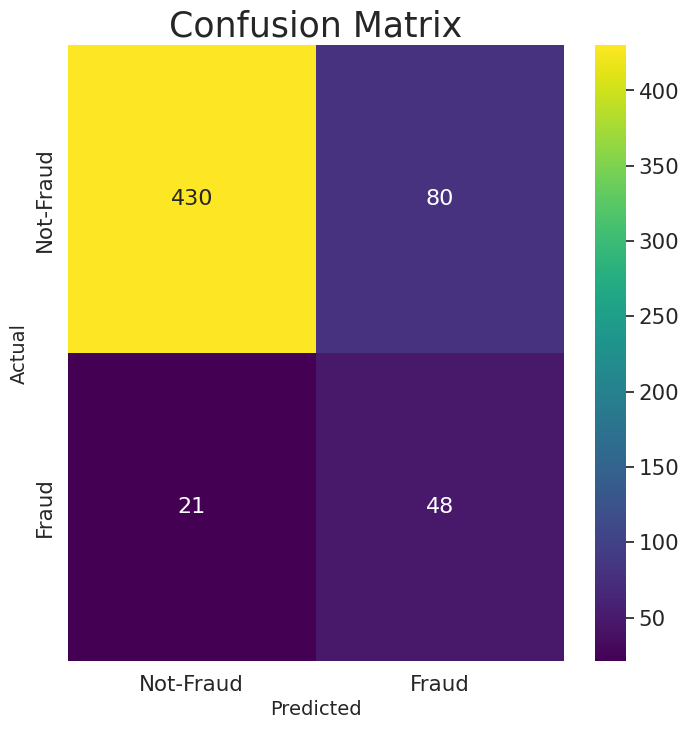

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

# Memprediksi label pada dataset evaluasi
predictions = trainer.predict(test_dataset)

# Mendapatkan label sebenarnya dan prediksi
true_labels = predictions.label_ids
predicted_labels = np.argmax(predictions.predictions, axis=-1)

# Menghitung confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Visualisasi confusion matrix dengan palet warna 'viridis'
fig, ax = plt.subplots(figsize=(8, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='viridis', xticklabels=label_mapping.keys(), yticklabels=label_mapping.keys(), annot_kws={"size": 16})  # Perbesar ukuran angka

plt.ylabel('Actual', fontsize=14)
plt.xlabel('Predicted', fontsize=14)
plt.title('Confusion Matrix', fontsize=25)
plt.show()


In [ ]:
# Tentukan lokasi penyimpanan model
model_path = "/content/drive/MyDrive/job-fraud-ads/7695_model"

# Simpan model
trainer.save_model(model_path)

# Jika Anda juga ingin menyimpan tokenizer
tokenizer.save_pretrained(model_path)

('/content/drive/MyDrive/job-fraud-ads/7695_model/tokenizer_config.json',
 '/content/drive/MyDrive/job-fraud-ads/7695_model/special_tokens_map.json',
 '/content/drive/MyDrive/job-fraud-ads/7695_model/vocab.txt',
 '/content/drive/MyDrive/job-fraud-ads/7695_model/added_tokens.json')

In [ ]:
!rm -r ./content